### Colab setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile
import os

def verify_unzip_file(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        for file_name in zip_ref.namelist():
            if file_name.startswith('__MACOSX'):
                continue
            file_path = os.path.join(extract_to, file_name)
            if not os.path.exists(file_path):
                zip_ref.extract(file_name, extract_to)
                print(f"Extracted: {file_name}")
            # else:
            #     print(f"Skipped (already exists): {file_name}")

zip_path = "drive/MyDrive/deepship_baseline_unnorm_mat.zip"
extract_to = "data"

if not os.path.exists(extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

verify_unzip_file(zip_path, extract_to)

### Imports

In [9]:
# Libraries
import os
from importlib import reload
import tensorflow as tf
import keras

import numpy as np
import matplotlib.pyplot as plt

# Scripts
from helpers import data, runners, utils, generators

In [10]:
# Should be v2.10
!pip show tensorflow

Name: tensorflow
Version: 2.17.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tf_keras


In [6]:
# Should be v2.10
!pip show keras

Name: keras
Version: 3.5.0
Summary: Multi-backend Keras.
Home-page: https://github.com/keras-team/keras
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache License 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, h5py, ml-dtypes, namex, numpy, optree, packaging, rich
Required-by: tensorflow


In [11]:
reload(runners)
reload(data)
reload(utils)
reload(generators)

<module 'helpers.generators' from '/content/helpers/generators.py'>

In [12]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

# Check whether tf is using the GPU
utils.check_gpu_use()

GPU DETECTED ✓
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## `main`

### Load data

In [13]:
NUM_FOLDS = 10
NUM_EPOCHS = 15
DATA_BATCH_SIZE = 16
GPU_BATCH_SIZE = 4

In [14]:
fold_dfs = data.get_fold_dfs(
    fold_definition_csv="deepship_5k_seg_3s.csv",
    new_path_to_root="data",
    ext="mat",
    n_folds=NUM_FOLDS,
    unix=True
)

In [15]:
train_df, val_df, test_df = data.generate_kth_fold(fold_dfs, test_idx=1, val_idx=0)

print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

del fold_dfs

(43470, 5)
(4534, 5)
(5498, 5)


In [16]:
train_gen = generators.DeepShipGenerator(
    df=train_df,
    ext="mat",
    mat_var_name="Ptrans",
    batch_size=DATA_BATCH_SIZE,
    shuffle=True,
    conv_channel=True,
    zero_one_normalised=True,
    X_only=True
)

val_gen = generators.DeepShipGenerator(
    df=val_df,
    ext="mat",
    mat_var_name="Ptrans",
    batch_size=DATA_BATCH_SIZE,
    shuffle=False,
    conv_channel=True,
    zero_one_normalised=True,
    X_only=True
)

test_gen = generators.DeepShipGenerator(
    df=test_df,
    ext="mat",
    mat_var_name="Ptrans",
    batch_size=DATA_BATCH_SIZE,
    shuffle=False,
    conv_channel=True,
    zero_one_normalised=True,
    X_only=True
)

### Initialise model

In [17]:
from models import irfan_2020, unet_n2n, unetpro
reload(unetpro)

# model = irfan_2020.get_irfan_model(input_shape=(192, 192, 1))
# model = unet_n2n.get_unet_model(input_shape=(192, 192, 1))
model = unetpro.get_unetpro_model(input_shape=(192, 192, 1))

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.99, epsilon=1e-8),
    loss=keras.losses.MeanSquaredError(),
    metrics=[utils.psnr]
)

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "unet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 192, 192, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gaussian_noise            │ (None, 192, 192, 1)    │              0 │ input_layer[0][0]      │
│ (GaussianNoise)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 192, 192, 8)    │             16 │ gaussian_noise[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 192, 192, 8)    │             80 │ gaussian_noise[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 192, 192, 8)    │            208 │ gaussian_noise[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 192, 192, 8)    │            400 │ gaussian_noise[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 192, 192, 8)    │             32 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 192, 192, 8)    │             32 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 192, 192, 8)    │             32 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 192, 192, 8)    │             32 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 192, 192, 8)    │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU) │ (None, 192, 192, 8)    │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU) │ (None, 192, 192, 8)    │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_3 (LeakyReLU) │ (None, 192, 192, 8)    │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 192, 192, 32)   │              0 │ leaky_re_lu[0][0],     │
│                           │                        │                │ leaky_re_lu_1[0][0],   │
│                           │                        │                │ leaky_re_lu_2[0][0],   │
│                           │                        │                │ leaky_re_lu_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1        

 Total params: 27,455,201 (104.73 MB)

 Trainable params: 27,449,313 (104.71 MB)

 Non-trainable params: 5,888 (23.00 KB)

### Train model

In [18]:
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath="drive/MyDrive/saved_models/same_spec/{epoch:02d}.keras",
    monitor='val_psnr',
    mode='max',
    save_best_only=True
)

csv_logger = keras.callbacks.CSVLogger(
    filename="drive/MyDrive/saved_models/same_spec/training.log",
    separator=",",
    append=True
)

backup_callback = keras.callbacks.BackupAndRestore(
    backup_dir="drive/MyDrive/saved_models/same_spec/tmp"
)

In [19]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    batch_size=GPU_BATCH_SIZE,
    epochs=NUM_EPOCHS,
    callbacks=[model_checkpoint_callback, csv_logger, backup_callback],
    verbose=2
)

Epoch 10/15
2716/2716 - 528s - 194ms/step - loss: 0.0029 - psnr: 25.4173 - val_loss: 0.0033 - val_psnr: 24.9737
Epoch 11/15
2716/2716 - 404s - 149ms/step - loss: 0.0029 - psnr: 25.4598 - val_loss: 0.0031 - val_psnr: 25.1853
Epoch 12/15
2716/2716 - 404s - 149ms/step - loss: 0.0028 - psnr: 25.4932 - val_loss: 0.0028 - val_psnr: 25.5748
Epoch 13/15
2716/2716 - 404s - 149ms/step - loss: 0.0028 - psnr: 25.5285 - val_loss: 0.0027 - val_psnr: 25.6849
Epoch 14/15
2716/2716 - 402s - 148ms/step - loss: 0.0028 - psnr: 25.5508 - val_loss: 0.0032 - val_psnr: 25.0100
Epoch 15/15
2716/2716 - 403s - 148ms/step - loss: 0.0028 - psnr: 25.5676 - val_loss: 0.0026 - val_psnr: 25.9230


In [20]:
evals = model.evaluate(
    test_gen,
    batch_size=GPU_BATCH_SIZE,
    verbose=2
)

343/343 - 17s - 50ms/step - loss: 0.0025 - psnr: 26.0233


In [21]:
model.save("drive/MyDrive/saved_models/same_spec/unetpro_15epochs.keras")

### Evaluation, metrics, and visualising denoised output

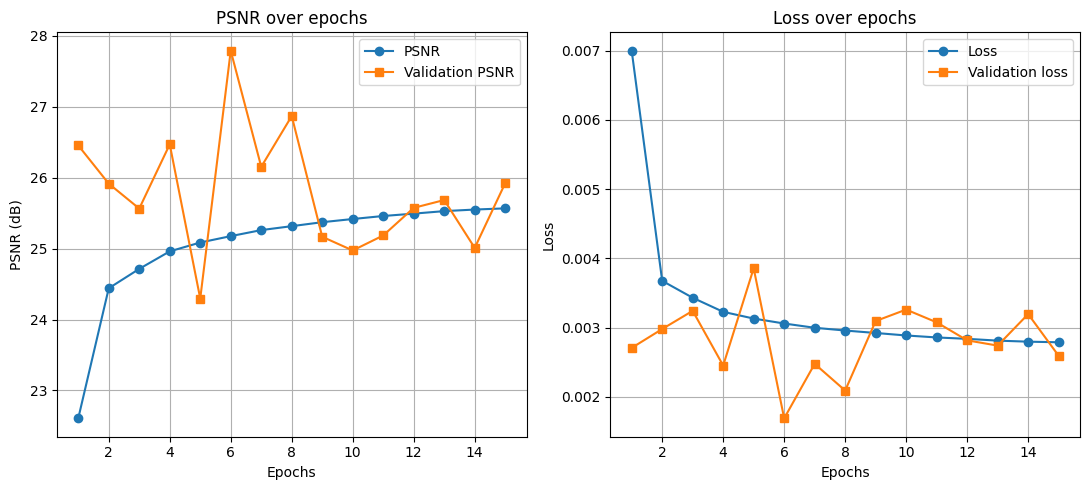

In [23]:
reload(utils)
fig = utils.get_psnr_and_loss_curves("drive/MyDrive/saved_models/same_spec/training.log", together=True)
fig.savefig("drive/MyDrive/saved_models/same_spec/img/psnr_loss_curves")

In [24]:
# Get a few samples from the test generator for visualisation and metrics calculation
num_samples = 5

sample_batch = next(iter(test_gen))[0]
sample_inputs = sample_batch[:num_samples]  # Extract the first `num_samples` examples from the batch

# Predict the denoised outputs
denoised_outputs = model.predict(sample_inputs)

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


In [25]:
# Get evaluation metrics
mse_score = tf.keras.losses.MeanSquaredError()(sample_inputs, denoised_outputs).numpy()
psnr_score = utils.psnr(sample_inputs, denoised_outputs).numpy()

print(f"MSE on sample batch: {mse_score}")
print(f"PSNR on sample batch: {psnr_score}")

MSE on sample batch: 0.0026584865991026163
PSNR on sample batch: [24.212093 26.605896 25.868301 25.91377  26.645744]


In [26]:
for i, output in enumerate(denoised_outputs):
    print(f"Sample {i+1} - Min: {np.min(output)}; Max: {np.max(output)}")

Sample 1 - Min: 0.09632506966590881; Max: 1.0
Sample 2 - Min: 0.1353183388710022; Max: 1.0
Sample 3 - Min: 0.09476720541715622; Max: 1.0
Sample 4 - Min: 0.1033167615532875; Max: 1.0
Sample 5 - Min: 0.1283184289932251; Max: 1.0


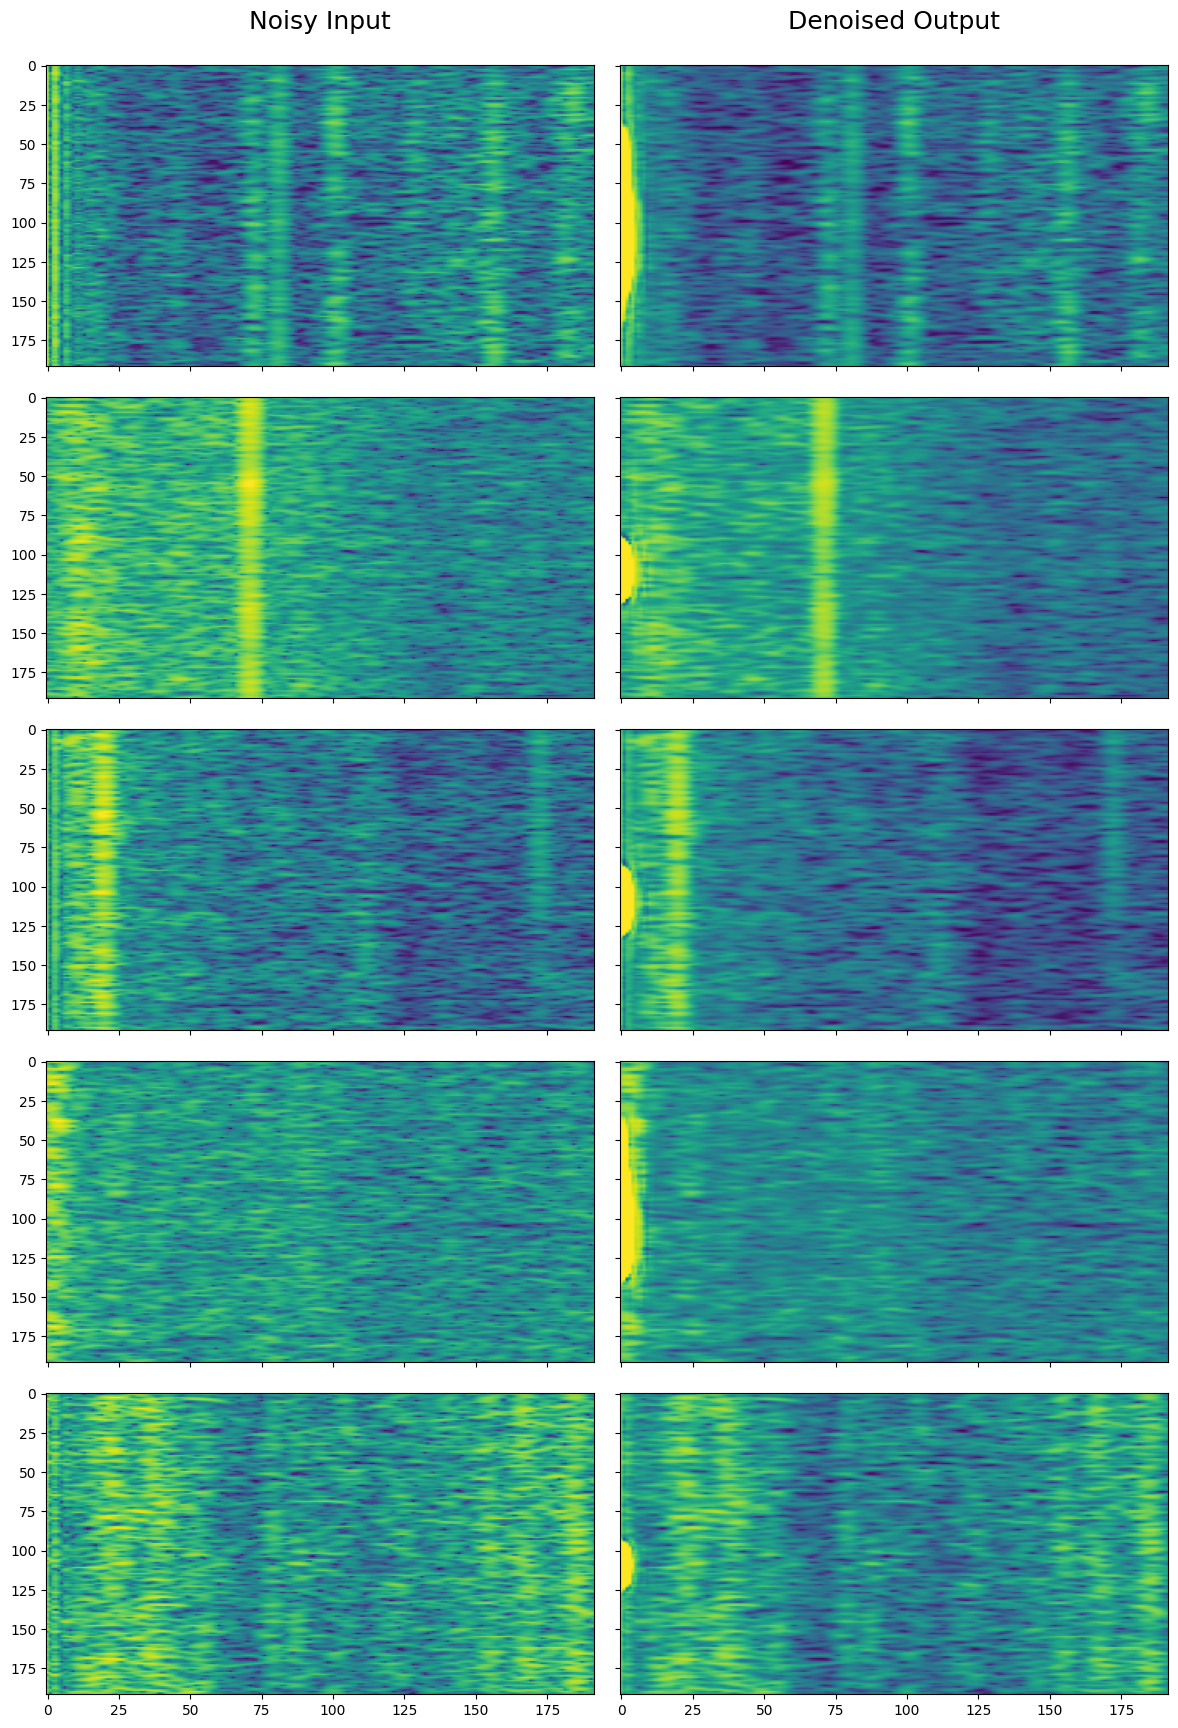

In [27]:
# Create a single figure
fig, axes = plt.subplots(num_samples, 2, figsize=(12, num_samples * 3.5), sharex=True, sharey=True)

for i in range(num_samples):
    axes[i, 0].imshow(sample_inputs[i].squeeze(), cmap="viridis", aspect="auto")
    axes[i, 1].imshow(denoised_outputs[i].squeeze(), cmap="viridis", aspect="auto")

axes[0, 0].set_title(f"Noisy Input\n", fontsize=18)
axes[0, 1].set_title(f"Denoised Output\n", fontsize=18)

fig.tight_layout(pad=1.5)
fig.savefig(f"drive/MyDrive/saved_models/same_spec/img/combined_spectrograms.pdf", bbox_inches="tight")

plt.show()

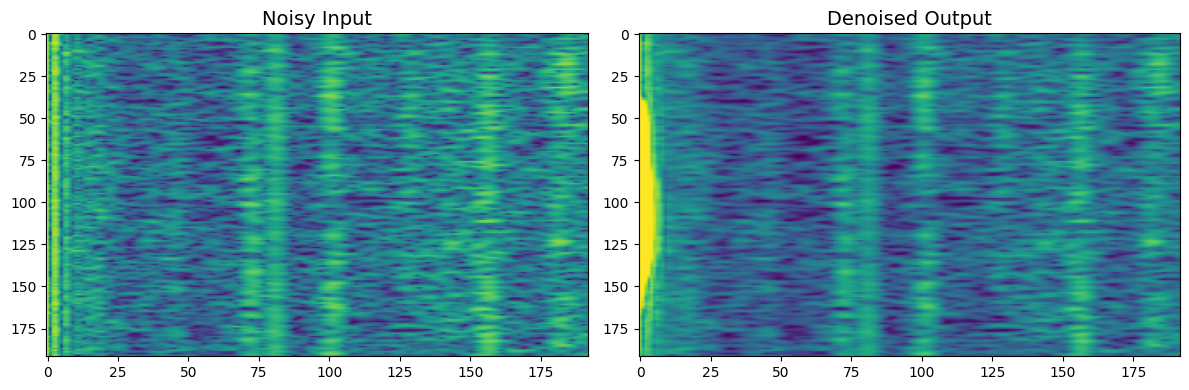

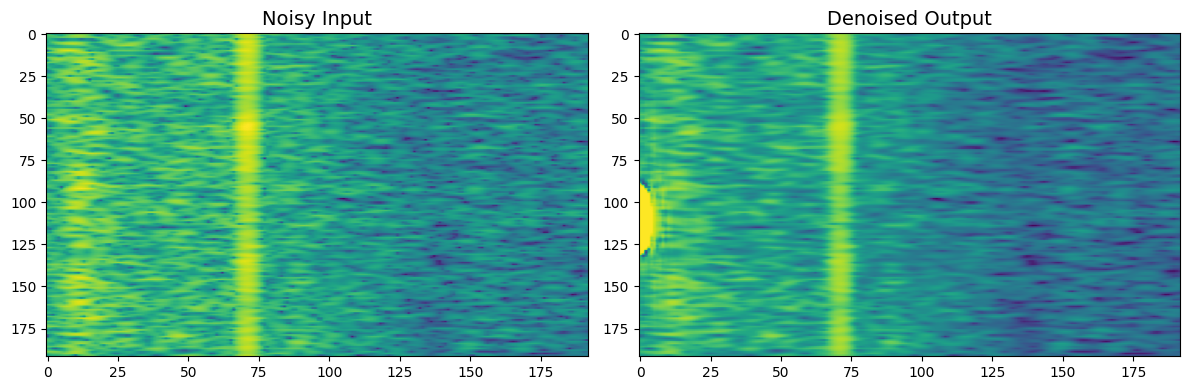

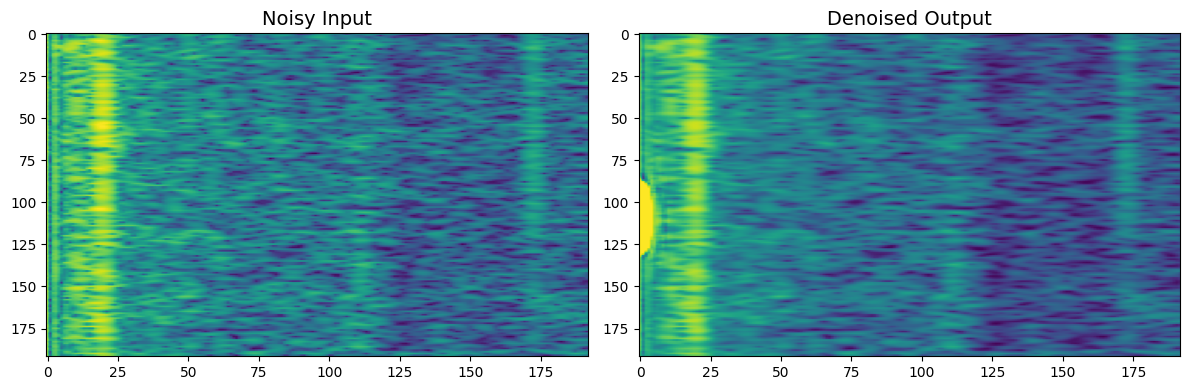

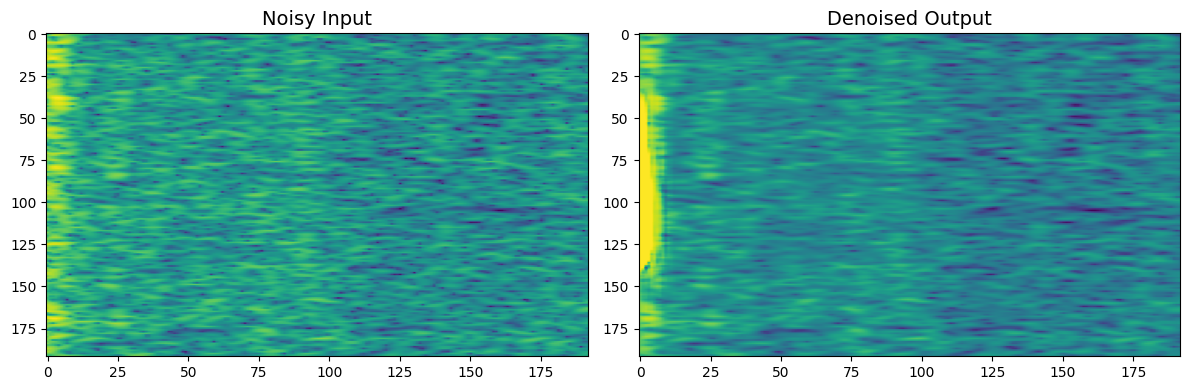

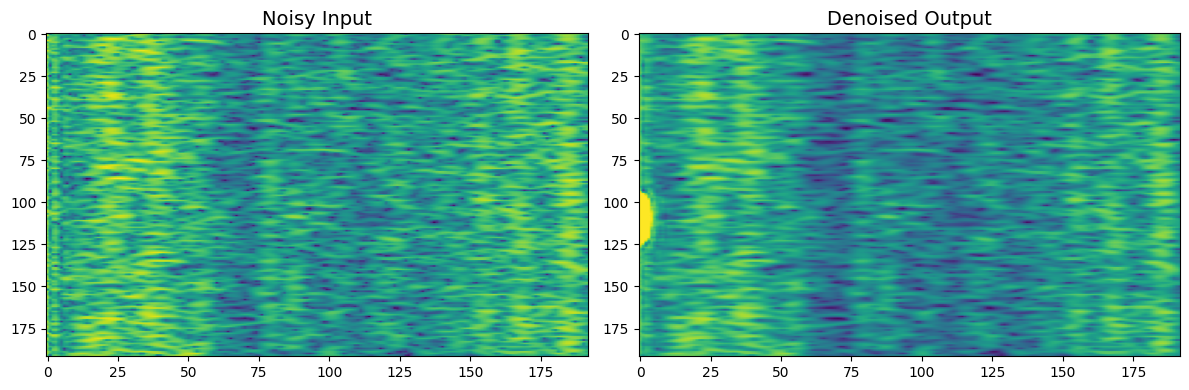

In [29]:
# Plot the input, output, and target spectrograms for each sample
for i in range(num_samples):
    fig = plt.figure(figsize=(12, 4))

    # Noisy Input
    plt.subplot(1, 2, 1)
    plt.imshow(sample_inputs[i].squeeze(), cmap="viridis", aspect="auto")
    plt.title("Noisy Input", fontdict={'size': 14})
    # plt.colorbar()

    # Denoised Output
    plt.subplot(1, 2, 2)
    plt.imshow(denoised_outputs[i].squeeze(), cmap="viridis", aspect="auto")
    plt.title("Denoised Output", fontdict={'size': 14})
    # plt.colorbar()

    plt.tight_layout()
    plt.show()

    fig.savefig(f"drive/MyDrive/saved_models/same_spec/img/ex{i + 1}.pdf")